In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from replay import Replay, State, Team
from bots.lgbm.preprocessing    import remove_menu_and_pause
from bots.lgbm.preprocessing    import who_scored
from bots.lgbm.preprocessing    import game_state_to_numpy

from typing import Optional
from sklearn.metrics import confusion_matrix, classification_report
from joblib import dump, load

import matplotlib.pyplot as plt
import numpy as np

In [21]:

def boolarr_to_class(y : [bool]) -> int:
    def boolarr_to_dirstate(y : [bool]) -> np.array:
        result = [0,0,0]
        if y[0]: #UP key pressed
            result[0] += 1
        if y[1]: #down key pressed
            result[0] -= 1

        if y[2]: #left
            result[1] += 1
        if y[3]: #right
            result[1] -= 1

        if y[4]:
            result[2] += 1

        return np.array(result)
    
    y = tuple(boolarr_to_dirstate(y))
    
    if y == tuple([0,0,0]):
        return 0
    elif y == tuple([0,0,1]):
        return 1
    
    elif y == tuple([-1,0,0]):
        return 2
    elif y == tuple([-1,0,1]):
        return 3
    
    elif y == tuple([0,-1,0]):
        return 4
    elif y == tuple([0,-1,1]):
        return 5
    
    elif y == tuple([1,0,0]):
        return 6
    elif y == tuple([1,0,1]):
        return 7
    
    elif y == tuple([0,1,0]):
        return 8
    elif y == tuple([0,1,1]):
        return 9
    
    elif y == tuple([1,1,0]):
        return 10
    elif y == tuple([1,1,1]):
        return 11
    
    elif y == tuple([-1,-1,0]):
        return 12
    elif y == tuple([-1,-1,1]):
        return 13
    
    elif y == tuple([-1,1,0]):
        return 14
    elif y == tuple([-1,1,1]):
        return 15
    
    elif y == tuple([1,-1,0]):
        return 16
    elif y == tuple([1,-1,1]):
        return 17
def prepare_train_data(episodes, stack_frames=4):
    # Take resultative episodes as training data
    train_x, train_y = [], []
    for episode in episodes:
        scorer = who_scored(episode)
        if scorer is not None:
            if scorer == Team.Blue:
                transform_blue_pivotal(episode)
            
            x = []
            y = []
            for e in episode:
                e_x, e_y = game_state_to_numpy(e, scorer)
                if e_x is not None and e_y is not None:
                    x.append(e_x)
                    y.append(e_y)
            
            # If there was no target player - ignore
            if x is not None and y is not None:
                train_x.append(x)
                train_y.append(y)
                
    # Stack n-frames
    x = []
    y = []
    for episode_i in range(len(train_x)):
        episode_x      = train_x[episode_i]
        episode_y      = train_y[episode_i]
        
        # Stacked samples
        train_sample = [episode_x[0] for _ in range(stack_frames)]
        
        x.append(np.concatenate(train_sample).ravel())
        y.append(boolarr_to_class(np.array(episode_y[0])))
        
        for frame_i in range(1, len(episode_x)):
            frame_x = episode_x[frame_i]
            frame_y = episode_y[frame_i]
            
            # Move stack
            for i in range(1, stack_frames):
                train_sample[i] = train_sample[i - 1]
            train_sample[0] = frame_x
            
            x.append(np.concatenate(train_sample).ravel())
            y.append(boolarr_to_class(np.array(frame_y)))
            
    return x, y

In [5]:
def transform_blue_pivotal(frames) -> Replay:
    """
    Inplace transformation of disk positions and velocities based on the pivotal team side.
    Inverse x-axis basically.
    
    frames: a list of replay frames
    """
    for frame in frames:
        if frame.players == None:
            continue
            
        for player in frame.players:
            # Inverse position and velocity along x-axis
            player.disc.x  = -player.disc.x
            player.disc.vx = -player.disc.vx
            
            # Swap left and right actions
            temp            = player.input[2]
            player.input[2] = player.input[3]
            player.input[3] = temp
            
        # Inverse position and velocity of the ball along x-axis
        frame.ball.x  = -frame.ball.x
        frame.ball.vx = -frame.ball.vx

In [6]:
import os

def prepare_train_data_folder(path):
    all_episodes = []
    num_games    = 0
    for file in os.listdir(path):
        if file[-4:] != ".bin":
            continue
            
        num_games += 1
        
        # Parse replay and etract game epsiodes
        _, replay = Replay(open(os.path.join(path, file), mode="rb").read())
        episodes = remove_menu_and_pause(replay)
        all_episodes.extend(episodes)
        
    print("Num episodes: {}".format(len(all_episodes)))
    print("Num games: {}".format(num_games))
    return prepare_train_data(all_episodes, 1)

In [7]:
import json

with open("../preprocessed/statistics.json") as f:
    names = json.load(f)

In [8]:
max_replays = 0
max_name    = None
for name in names.keys():
    if len(names[name]) > max_replays:
        max_replays = len(names[name])
        max_name = name

In [9]:
max_replays

26

In [10]:
max_name

'Saviour'

In [11]:
all_episodes = []
for relative_path in names[max_name][:2]:
    path = ".."
    # Parse replay and etract game epsiodes
    _, replay = Replay(open(os.path.join(path, relative_path), mode="rb").read())
    episodes = remove_menu_and_pause(replay)
    all_episodes.extend(episodes)

In [12]:
len(all_episodes)

42

In [22]:
t1, t2 = prepare_train_data(all_episodes, 1)#prepare_train_data_folder("replays/cups/edition7/")

In [24]:
import lightgbm as lgb

In [38]:
imitator = lgb.LGBMClassifier(n_estimators=400)

In [39]:
imitator.fit(t1, t2)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [40]:
t2_pred = imitator.predict(t1)

In [28]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


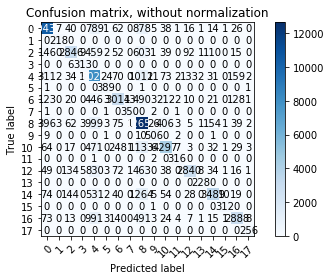

In [29]:
plot_confusion_matrix(t2, t2_pred.astype(int), list(range(18)))
plt.show()

In [30]:
# 100 estimators
print(classification_report(t2, t2_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     12313
           1       0.95      1.00      0.97       218
           2       0.86      0.65      0.74      4375
           3       0.95      0.98      0.96       319
           4       0.59      0.81      0.68      9892
           5       0.90      0.99      0.94       392
           6       0.80      0.67      0.73      4486
           7       0.96      0.99      0.97       355
           8       0.67      0.85      0.75     14831
           9       0.89      0.96      0.92       529
          10       0.83      0.68      0.75      6312
          11       0.93      0.99      0.96       319
          12       0.91      0.63      0.74      4495
          13       0.94      1.00      0.97       228
          14       0.89      0.62      0.73      5660
          15       0.95      1.00      0.97       313
          16       0.87      0.62      0.72      4662
          17       0.93    

In [42]:
dump(imitator, 'imitator1.joblib')

['imitator1.joblib']

Confusion matrix, without normalization


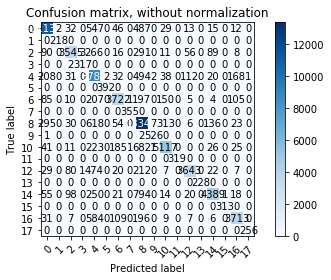

In [35]:
plot_confusion_matrix(t2, t2_pred.astype(int), list(range(18)))
plt.show()

In [36]:
# 200 estimators
print(classification_report(t2, t2_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92     12313
           1       0.99      1.00      1.00       218
           2       0.92      0.81      0.86      4375
           3       0.99      0.99      0.99       319
           4       0.73      0.89      0.80      9892
           5       0.99      1.00      1.00       392
           6       0.89      0.83      0.86      4486
           7       0.99      1.00      1.00       355
           8       0.80      0.90      0.85     14831
           9       0.98      0.99      0.99       529
          10       0.90      0.81      0.85      6312
          11       1.00      1.00      1.00       319
          12       0.94      0.81      0.87      4495
          13       1.00      1.00      1.00       228
          14       0.93      0.78      0.85      5660
          15       1.00      1.00      1.00       313
          16       0.91      0.80      0.85      4662
          17       1.00    

In [41]:
# 400 estimators
print(classification_report(t2, t2_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     12313
           1       1.00      1.00      1.00       218
           2       0.97      0.93      0.95      4375
           3       0.99      0.99      0.99       319
           4       0.90      0.96      0.93      9892
           5       1.00      1.00      1.00       392
           6       0.96      0.93      0.95      4486
           7       1.00      1.00      1.00       355
           8       0.92      0.96      0.94     14831
           9       1.00      1.00      1.00       529
          10       0.96      0.92      0.94      6312
          11       1.00      1.00      1.00       319
          12       0.98      0.93      0.95      4495
          13       1.00      1.00      1.00       228
          14       0.97      0.92      0.94      5660
          15       1.00      1.00      1.00       313
          16       0.96      0.94      0.95      4662
          17       1.00    